<div align="center">

# Instituto Tecnológico y de Estudios Superiores de Monterrey

**Septiembre–Diciembre 2025**
**Maestría en Inteligencia Artificial Aplicada**

## Avance 1

**Análisis exploratorio de datos**

---

### Equipo académico

|                  | **Nombre**                            |
| ---------------- | ------------------------------------- |
| Profesor Titular | Dra. Grettel Barceló Alonso           |
| Asesora          | Dra. Ludivina Facundo Flores          |
| Tutor            | Mtra. Verónica Sandra Guzmán de Valle |
| Sponsor          | Dr. Jesús Arturo Pérez Díaz           |

---

### Proyecto Integrador

**TC5035.10**

---

### Integrantes

| **Nombre**                        | **Matrícula** |
| --------------------------------- | ------------- |
| Christopher Adolfo Orduña De León | A01795372     |
| Miguel Ángel Paredes Gutiérrez    | A01794138     |
| Carlos Mariano Ramírez Amaya      | A01795036     |

**Fecha:** 27 de septiembre del 2025

</div>


# Incidente BGP de 18 minutos atribuido a China Telecom (8-abr-2010)

- **Fecha y hora (UTC):** 17:54:31 → 18:10:14  
- **Duración:** ≈ 18 minutos  
- **Hora local (CDMX):** 12:54 → 13:10  
- **ASNs clave:**  
  - **AS23724** (CHINANET-IDC-BJ-AP, China Telecom) — origen de anuncios indebidos  
  - **AS4134** (CHINANET-BACKBONE) — propagación de rutas  
- **Firma AS-PATH típica:** `4134 23724 23724`  
- **Magnitud:** ~37k–50k prefijos anunciados indebidamente  
  - **Ejemplos:** `66.174.161.0/24` (Verizon Wireless), `203.190.56.0/21`
- **Naturaleza del evento:** *route leak* masivo (no un secuestro dirigido), con potencial de desvío/intercepción de tráfico en algunos casos.  
- **Operadores impactados/observadores (ejemplos):** AS7018 (AT&T), AS3356 (Level 3), AS22394 (Verizon Wireless).  

# Diccionario de abreviaturas citadas:

* **BGP** — *Border Gateway Protocol*: protocolo de enrutamiento entre Sistemas Autónomos en Internet.
* **AS** — *Autonomous System*: red o conjunto de redes bajo una misma política de enrutamiento.
* **ASN** — *Autonomous System Number*: identificador numérico único de un AS (ej. **4134**).
* **AS-PATH** — Atributo BGP que lista, en orden, los **ASNs** atravesados por una ruta.
* **A** — *Announcement* (anuncio): mensaje BGP que **publica**/actualiza una ruta.
* **W** — *Withdrawal* (retiro): mensaje BGP que **retira**/invalida una ruta previamente anunciada.
* **MOAS** — *Multiple Origin AS*: situación en la que un **mismo prefijo** se anuncia con **múltiples AS de origen** simultáneamente.
* **PR-AUC** — *Precision–Recall Area Under Curve*: área bajo la curva Precisión–Recall; métrica robusta en escenarios desbalanceados.
* **F1** — *F1-score*: media armónica entre **precisión** y **exhaustividad** (recall).
* **p95** — *Percentil 95*: valor por debajo del cual se encuentra el 95% de las observaciones (útil para resumir colas pesadas).


## 0) Imports, configuración y carga de datos

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
import os

os.chdir('../data')

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress
import re

# Ruta del dataset (AJUSTA si es necesario)
DATA_DIR = Path("raw/")
PATH = DATA_DIR / "chinatelecom_april_08_2010_all_collectors_ipv4.parquet"

df = pd.read_parquet(PATH, engine="pyarrow")
print("Shape: ", df.shape)
print("Columnas:", list(df.columns))

# Unifica tiempo a 't' (UTC)
if "t" not in df.columns:
    if "formatted_time" in df.columns:
        df["t"] = pd.to_datetime(df["formatted_time"], utc=True, errors="coerce")
    elif "time" in df.columns:
        df["t"] = pd.to_datetime(df["time"], unit="s", utc=True, errors="coerce")
    else:
        raise ValueError("No se encontró 't', 'formatted_time' ni 'time'.")

# Mantiene solo filas con tiempo válido
df = df[df["t"].notna()].copy()

# Rango temporal del archivo
t_min, t_max = df["t"].min(), df["t"].max()
print("Rango temporal (UTC):", t_min, "→", t_max)

# Ventanas del incidente (con intersección para robustez)
EVENT_START = pd.Timestamp("2010-04-08 17:54:31", tz="UTC")
EVENT_END   = pd.Timestamp("2010-04-08 18:10:14", tz="UTC")
WIN_EVENT = (max(EVENT_START, t_min), min(EVENT_END, t_max))

# Baselines: 5 min antes y 5 min después
PRE_WIN  = (WIN_EVENT[0] - pd.Timedelta(minutes=5), WIN_EVENT[0])
POST_WIN = (WIN_EVENT[1], WIN_EVENT[1] + pd.Timedelta(minutes=5))

# Recorta a rango de datos
PRE_WIN  = (max(PRE_WIN[0], t_min),  min(PRE_WIN[1],  t_max))
POST_WIN = (max(POST_WIN[0], t_min), min(POST_WIN[1], t_max))

print("Ventana PRE  :", PRE_WIN)
print("Ventana EVENT:", WIN_EVENT)
print("Ventana POST :", POST_WIN)

# Asegura tipos esperados
df["type"] = df["type"].astype(str) if "type" in df.columns else "A"


Shape:  (326208, 14)
Columnas: ['as_path', 'collector', 'communities', 'formatted_time', 'local_pref', 'med', 'next_hop', 'origin', 'peer_asn', 'peer_ip', 'prefix', 'project', 'time', 'type']
Rango temporal (UTC): 2010-04-08 17:50:31+00:00 → 2010-04-08 18:14:14+00:00
Ventana PRE  : (Timestamp('2010-04-08 17:50:31+0000', tz='UTC'), Timestamp('2010-04-08 17:54:31+0000', tz='UTC'))
Ventana EVENT: (Timestamp('2010-04-08 17:54:31+0000', tz='UTC'), Timestamp('2010-04-08 18:10:14+0000', tz='UTC'))
Ventana POST : (Timestamp('2010-04-08 18:10:14+0000', tz='UTC'), Timestamp('2010-04-08 18:14:14+0000', tz='UTC'))


## 1) Funciones comunes

In [4]:
def is_ipv4(prefix) -> bool:
    try:
        return ipaddress.ip_network(prefix, strict=False).version == 4
    except Exception:
        return False

def tokenize_path(path: str):
    if not isinstance(path, str): 
        return []
    clean = re.sub(r"[\{\}\(\)]", " ", path)
    return [tok for tok in clean.split() if tok.isdigit()]

def origin_asn(path: str):
    toks = tokenize_path(path)
    return int(toks[-1]) if toks else None

def transit_asns(path: str):
    toks = tokenize_path(path)
    return toks[:-1] if len(toks) >= 2 else []

def ensure_as_path_length(frame: pd.DataFrame) -> pd.DataFrame:
    if "as_path_length" not in frame.columns:
        frame["as_path_length"] = (
            frame["as_path"]
            .where(frame["as_path"].notna(), None)
            .apply(lambda x: len(str(x).split()) if isinstance(x, str) and x.strip() else np.nan)
        )
    return frame

# Vista vantage-point = df tal cual
df_vp = df.copy()

# Vista agregada por segundo y prefijo (evita sobrerrepresentar múltiples vantage points)
# Clave: (segundo, prefix, type)
df_ag = df.copy()
df_ag["sec"] = df_ag["t"].dt.floor("s")
agg_keys = ["sec", "prefix", "type"]
present = [c for c in agg_keys if c in df_ag.columns]
df_ag = df_ag.dropna(subset=["sec", "prefix"])
df_ag = df_ag.groupby(present, dropna=False).size().reset_index(name="events")
df_ag.rename(columns={"sec":"t_sec"}, inplace=True)

print(f"Vantage-point rows: {len(df_vp):,}")
print(f"Agregado (t,prefix,type) por segundo: {len(df_ag):,}")

Vantage-point rows: 326,208
Agregado (t,prefix,type) por segundo: 179,491


## 2) Resúmenes básicos (conteos y cardinalidades)

In [5]:
from IPython.display import display

print("Eventos por tipo (vantage-point):")
display(df_vp["type"].value_counts().to_frame("events"))

if {"collector","type"}.issubset(df_vp.columns):
    print("\nEventos por colector y tipo (vantage-point):")
    display(df_vp.groupby(["collector","type"]).size().reset_index(name="events").sort_values("events", ascending=False))

if "prefix" in df_vp.columns:
    print("\nTop 20 prefijos por eventos (vantage-point):")
    display(df_vp["prefix"].value_counts().head(20).to_frame("events"))

if {"collector","peer_asn"}.issubset(df_vp.columns):
    print("\nPeers únicos por colector (vantage-point):")
    display(df_vp.groupby("collector")["peer_asn"].nunique().sort_values(ascending=False).to_frame("unique_peer_asn"))

# Cardinalidades clave
print("\nCardinalidades:")
print("type:", df_vp["type"].nunique() if "type" in df_vp.columns else "N/A")
print("collector:", df_vp["collector"].nunique() if "collector" in df_vp.columns else "N/A")
print("prefix:", df_vp["prefix"].nunique() if "prefix" in df_vp.columns else "N/A")
print("peer_asn:", df_vp["peer_asn"].nunique() if "peer_asn" in df_vp.columns else "N/A")


Eventos por tipo (vantage-point):


,events
type,
A,280481
W,45727



Eventos por colector y tipo (vantage-point):


,collector,type,events
4,route-views.linx,A,93967
10,rrc01,A,42785
0,route-views.eqix,A,41424
2,route-views.isc,A,39382
8,rrc00,A,29646
12,rrc11,A,25470
11,rrc01,W,15726
5,route-views.linx,W,13088
6,route-views.wide,A,7807
1,route-views.eqix,W,4254



Top 20 prefijos por eventos (vantage-point):


,events
prefix,
199.60.22.0/24,8602
200.11.29.0/24,2885
208.98.230.0/24,2632
208.98.231.0/24,2500
204.124.160.0/22,2144
194.36.8.0/22,2024
180.233.225.0/24,1499
194.0.142.0/24,1124
193.176.206.0/23,1085



Peers únicos por colector (vantage-point):


,unique_peer_asn
collector,
rrc01,29
route-views.linx,19
rrc11,14
route-views.isc,10
route-views.eqix,10
rrc00,10
route-views.wide,4



Cardinalidades:
type: 2
collector: 7
prefix: 9147
peer_asn: 67


## 3) Series A/W (1s y 1min) + ratio A/(A+W) y sombreado de ventanas

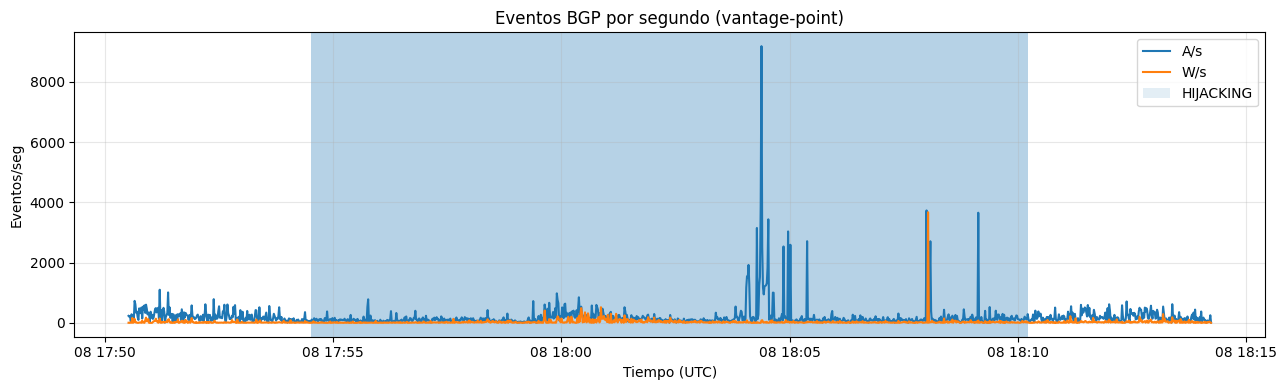

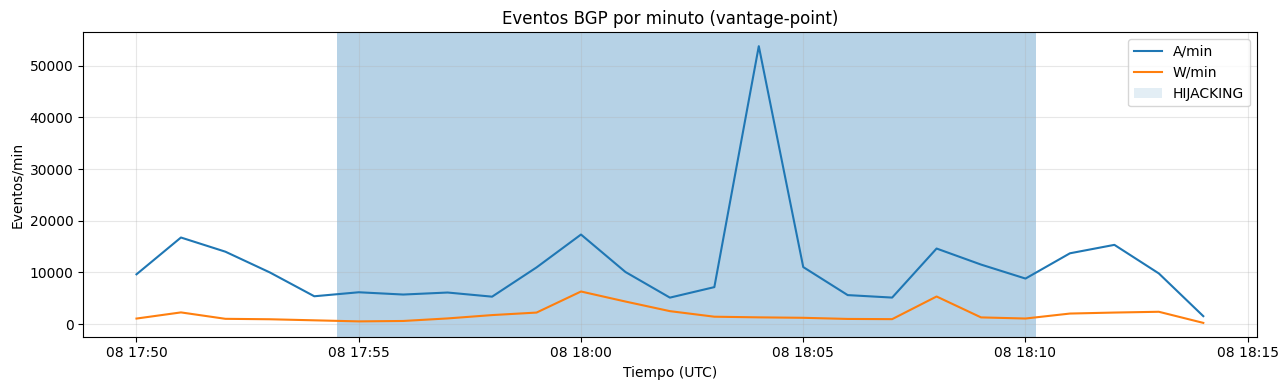

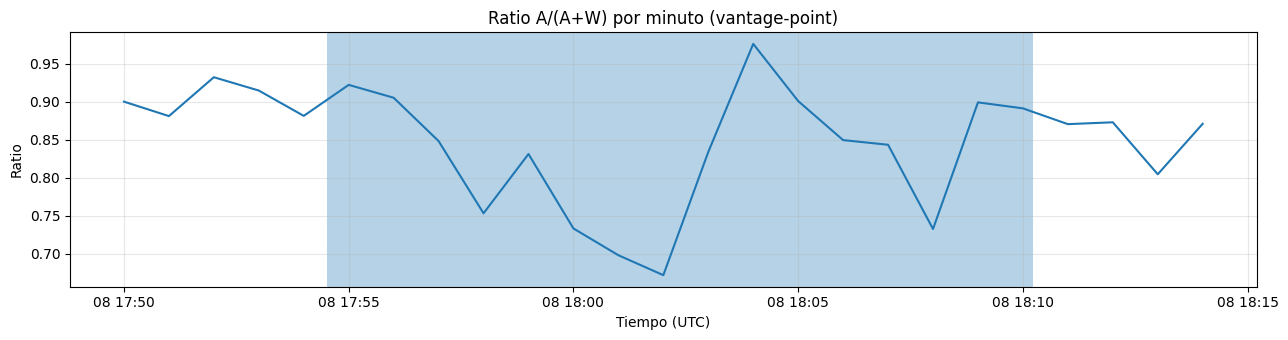

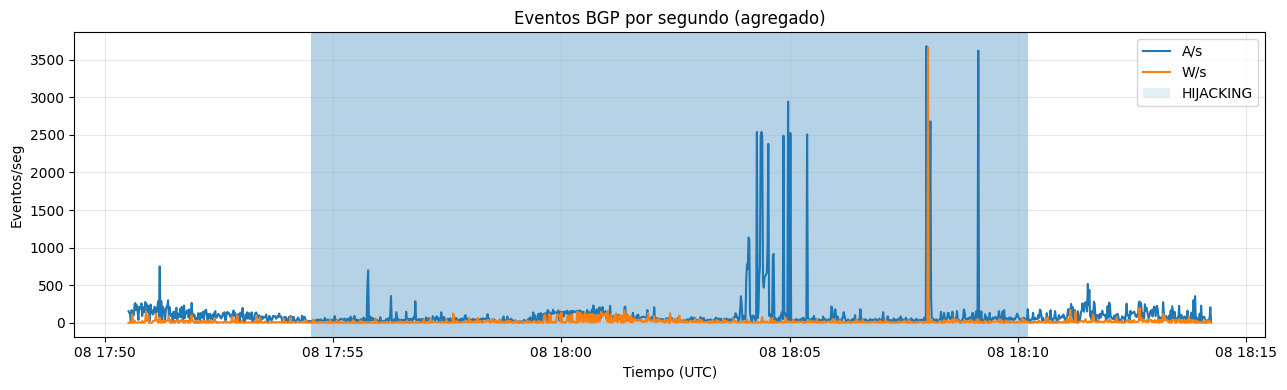

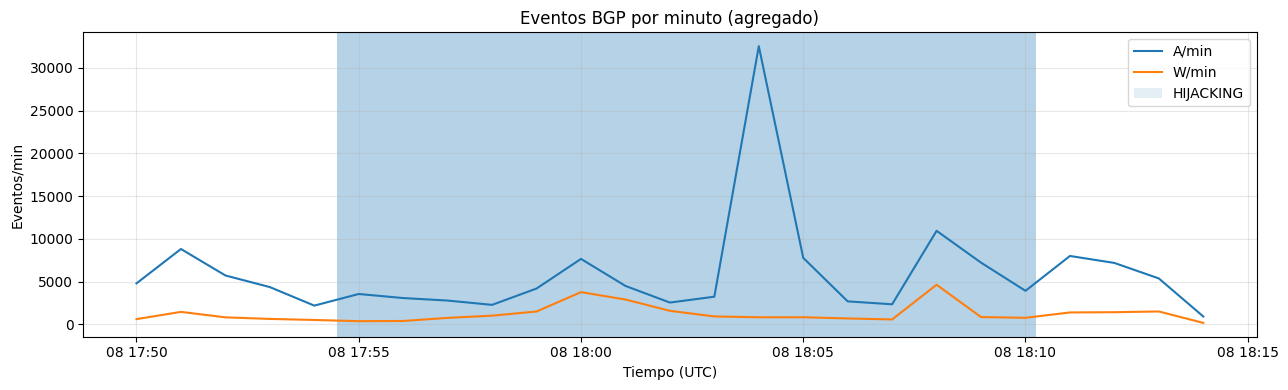

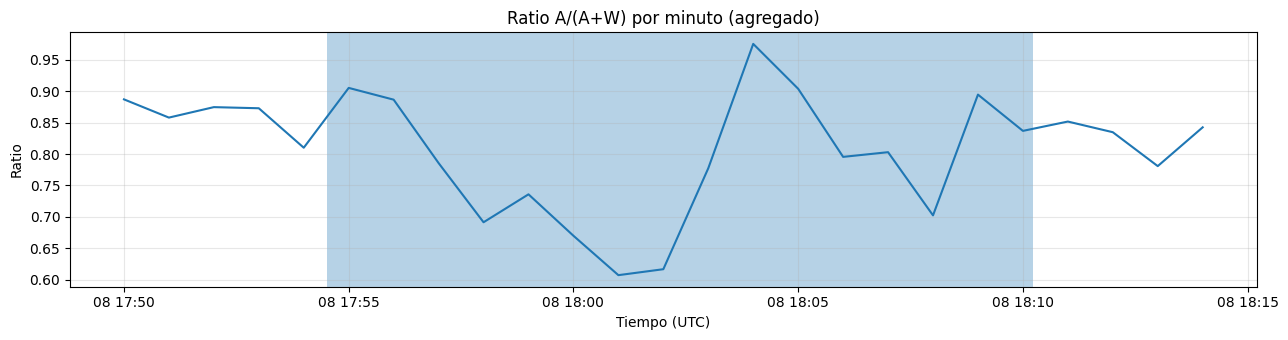

In [6]:
def plot_aw_series(frame: pd.DataFrame, idx_col="t", title_suffix="(vantage-point)"):
    s = frame[frame["type"].isin(["A","W"])].dropna(subset=[idx_col]).set_index(idx_col)

    # 1 segundo
    g1 = s.groupby("type").resample("1S").size().unstack(0).fillna(0)
    for col in ["A","W"]:
        if col not in g1.columns: g1[col] = 0
    g1 = g1[["A","W"]]
    ratio1 = g1["A"] / (g1["A"] + g1["W"]).replace(0, np.nan)

    plt.figure(figsize=(13,4))
    plt.plot(g1.index, g1["A"], label="A/s")
    plt.plot(g1.index, g1["W"], label="W/s")
    # Sombreado ventanas
    for (a,b), lbl in [(PRE_WIN,"PRE"), (WIN_EVENT,"EVENT"), (POST_WIN,"POST")]:
        plt.axvspan('2010-04-08 17:54:31+00:00', '2010-04-08 18:10:14+00:00', alpha=0.12, label='HIJACKING' if a==PRE_WIN[0] else None)

    plt.title(f"Eventos BGP por segundo {title_suffix}")
    plt.xlabel("Tiempo (UTC)"); plt.ylabel("Eventos/seg"); plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()
    
    # 1 minuto
    g2 = s.groupby("type").resample("1min").size().unstack(0).fillna(0)
    for col in ["A","W"]:
        if col not in g2.columns: g2[col] = 0
    g2 = g2[["A","W"]]
    ratio2 = g2["A"] / (g2["A"] + g2["W"]).replace(0, np.nan)

    plt.figure(figsize=(13,4))
    plt.plot(g2.index, g2["A"], label="A/min")
    plt.plot(g2.index, g2["W"], label="W/min")
    for (a,b), lbl in [(PRE_WIN,"PRE"), (WIN_EVENT,"EVENT"), (POST_WIN,"POST")]:
        plt.axvspan('2010-04-08 17:54:31+00:00', '2010-04-08 18:10:14+00:00', alpha=0.12, label='HIJACKING' if a==PRE_WIN[0] else None)
    plt.title(f"Eventos BGP por minuto {title_suffix}")
    plt.xlabel("Tiempo (UTC)"); plt.ylabel("Eventos/min"); plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    # Ratio por minuto
    plt.figure(figsize=(13,3.5))
    plt.plot(ratio2.index, ratio2.values)
    for (a,b), lbl in [(PRE_WIN,"PRE"), (WIN_EVENT,"EVENT"), (POST_WIN,"POST")]:
        plt.axvspan('2010-04-08 17:54:31+00:00', '2010-04-08 18:10:14+00:00', alpha=0.12, label='HIJACKING' if a==PRE_WIN[0] else None)
    plt.title(f"Ratio A/(A+W) por minuto {title_suffix}")
    plt.xlabel("Tiempo (UTC)"); plt.ylabel("Ratio"); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# Vantage-point
plot_aw_series(df_vp, idx_col="t", title_suffix="(vantage-point)")

# Agregado por segundo/prefijo/type: reconstituye un índice temporal por 't_sec'
if {"t_sec","type"}.issubset(df_ag.columns):
    tmp = df_ag.rename(columns={"t_sec":"t"})
    plot_aw_series(tmp, idx_col="t", title_suffix="(agregado)")


## 4) Longitud de AS-PATH: distribución, p50/p95 por minuto y outliers

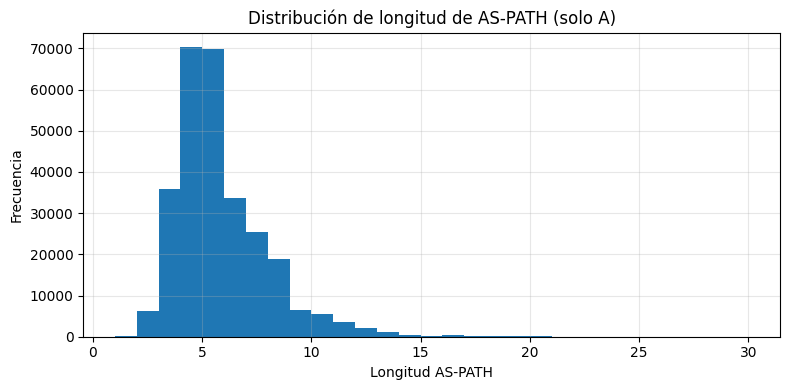

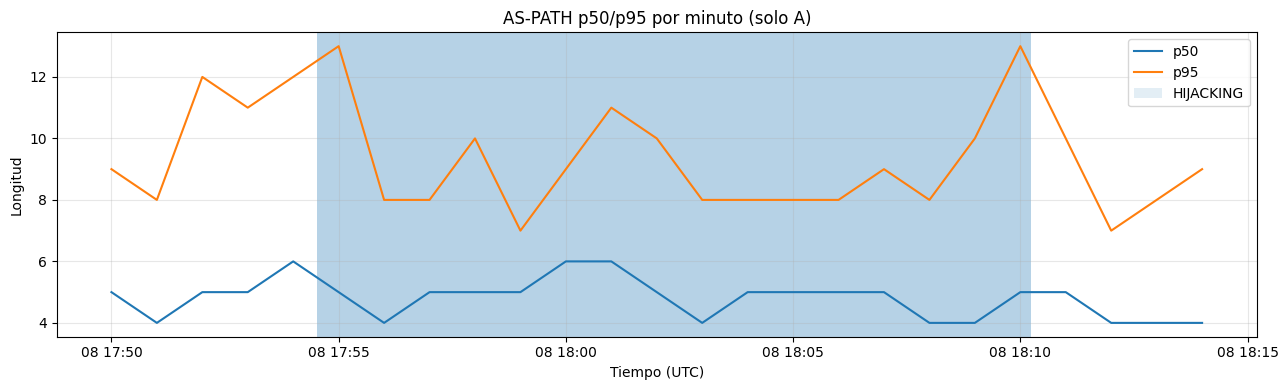

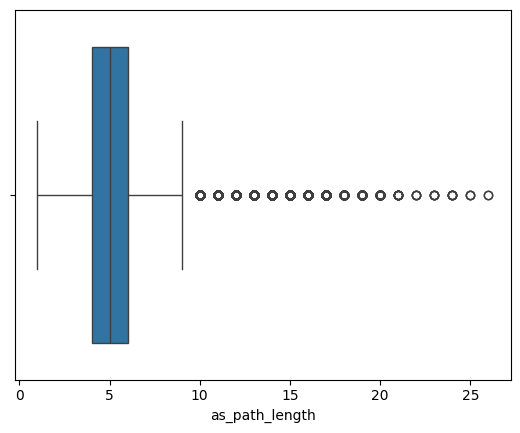

P99 longitud: 12.00 | outliers arriba de P99: 2778


,t,collector,peer_asn,prefix,as_path_length,as_path
106,2010-04-08 17:50:33+00:00,route-views.eqix,3257,114.31.245.0/24,13,3257 7473 45147 45147 45147 38525 18351 18351 ...
112,2010-04-08 17:50:33+00:00,route-views.eqix,4436,114.31.245.0/24,13,4436 7473 45147 45147 45147 38525 18351 18351 ...
113,2010-04-08 17:50:33+00:00,route-views.eqix,4436,114.31.245.0/24,13,4436 7473 45147 45147 45147 38525 18351 18351 ...
114,2010-04-08 17:50:34+00:00,route-views.eqix,2914,114.31.245.0/24,14,2914 3257 7473 45147 45147 45147 38525 18351 1...
115,2010-04-08 17:50:36+00:00,route-views.eqix,4436,116.66.202.0/24,13,4436 7473 45147 45147 45147 38525 18351 18351 ...
116,2010-04-08 17:50:36+00:00,route-views.eqix,4436,116.66.202.0/24,13,4436 7473 45147 45147 45147 38525 18351 18351 ...
135,2010-04-08 17:50:40+00:00,route-views.eqix,3257,116.66.202.0/24,13,3257 7473 45147 45147 45147 38525 18351 18351 ...
450,2010-04-08 17:50:43+00:00,route-views.eqix,41095,116.66.202.0/24,13,41095 7473 45147 45147 45147 38525 18351 18351...
2907,2010-04-08 17:51:25+00:00,route-views.eqix,11666,116.66.202.0/24,13,11666 7473 45147 45147 45147 38525 18351 18351...
3917,2010-04-08 17:51:44+00:00,route-views.eqix,41095,204.124.160.0/22,14,41095 3356 4314 21637 21637 21637 21637 21637 ...


In [7]:
dA = df_vp[df_vp["type"]=="A"].copy()
dA = ensure_as_path_length(dA)

# Histograma (bins 1..30)
plt.figure(figsize=(8,4))
dA["as_path_length"].dropna().astype(int).plot.hist(bins=range(1,31))
plt.title("Distribución de longitud de AS-PATH (solo A)")
plt.xlabel("Longitud AS-PATH"); plt.ylabel("Frecuencia")
for (a,b), lbl in [(PRE_WIN,"PRE"), (WIN_EVENT,"EVENT"), (POST_WIN,"POST")]:
    # solo título; el hist no es temporal
    pass
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# p50/p95 por minuto
q = (dA.dropna(subset=["t"])
       .set_index("t")
       .resample("1min")["as_path_length"]
       .quantile([0.5, 0.95])
       .unstack())
q.columns = ["p50","p95"]

plt.figure(figsize=(13,4))
plt.plot(q.index, q["p50"], label="p50")
plt.plot(q.index, q["p95"], label="p95")
for (a,b), lbl in [(PRE_WIN,"PRE"), (WIN_EVENT,"EVENT"), (POST_WIN,"POST")]:
    plt.axvspan('2010-04-08 17:54:31+00:00', '2010-04-08 18:10:14+00:00', alpha=0.12, label='HIJACKING' if a==PRE_WIN[0] else None)
plt.title("AS-PATH p50/p95 por minuto (solo A)")
plt.xlabel("Tiempo (UTC)"); plt.ylabel("Longitud"); plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

sns.boxplot(data=dA, x='as_path_length')
plt.show()

# Outliers por P99
p99 = dA["as_path_length"].dropna().quantile(0.99)
outliers = dA[dA["as_path_length"] > p99]
print(f"P99 longitud: {p99:.2f} | outliers arriba de P99: {len(outliers)}")
display(outliers[["t","collector","peer_asn","prefix","as_path_length","as_path"]].head(10))


## 5) Bivariado: colector × tipo y prefix × origin (top-k)

In [8]:
from IPython.display import display

# Colector x tipo (conteos)
if {"collector","type"}.issubset(df_vp.columns):
    ctab = pd.crosstab(df_vp["collector"], df_vp["type"])
    display(ctab.sort_values(ctab.columns.tolist(), ascending=False))

# Origen ASN
dA["origin_asn"] = dA["as_path"].apply(origin_asn)

# Prefix x origin_asn (top 20 prefijos y top 20 orígenes)
top_p = dA["prefix"].value_counts().head(20).index
top_o = dA["origin_asn"].dropna().astype(int).value_counts().head(20).index
pivot = (dA[dA["prefix"].isin(top_p) & dA["origin_asn"].isin(top_o)]
         .pivot_table(index="prefix", columns="origin_asn", values="as_path", aggfunc="count", fill_value=0))
display(pivot)

type,A,W
collector,,
route-views.linx,93967,13088
rrc01,42785,15726
route-views.eqix,41424,4254
route-views.isc,39382,3488
rrc00,29646,4058
rrc11,25470,3939
route-views.wide,7807,1174


origin_asn,5839,18747
prefix,,
138.180.195.0/24,637,0
138.180.196.0/24,637,0
138.180.198.0/24,784,0
199.60.22.0/24,0,6631


## 6) Métricas fuertes: MOAS (múltiples orígenes)

Prefijos con MOAS (>1 origen) en el dataset: 50


,distinct_origins
prefix,
222.126.240.0/20,2
205.71.0.0/20,2
205.70.0.0/19,2
205.69.128.0/19,2
205.66.88.0/24,2
205.64.0.0/19,2
194.0.190.0/24,2
205.62.0.0/19,2
205.61.0.0/19,2


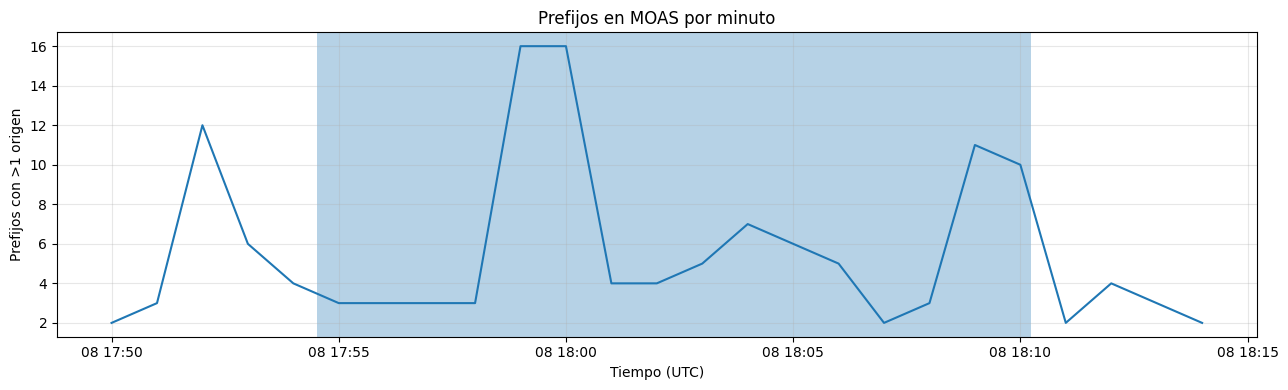

In [9]:
# Distintos orígenes por prefijo en toda la ventana
moas = (dA.dropna(subset=["origin_asn"])
          .groupby("prefix")["origin_asn"]
          .nunique()
          .sort_values(ascending=False))
moas_alert = moas[moas > 1]
print(f"Prefijos con MOAS (>1 origen) en el dataset: {len(moas_alert):,}")
display(moas_alert.head(20).to_frame("distinct_origins"))

# MOAS por minuto (cuántos prefijos tienen >1 origen en cada minuto)
moas_min = (dA.dropna(subset=["t","origin_asn"])
              .set_index("t")
              .groupby([pd.Grouper(freq="1min"), "prefix"])["origin_asn"]
              .nunique()
              .reset_index())
moas_agg = moas_min.groupby("t")["origin_asn"].apply(lambda s: (s > 1).sum())

plt.figure(figsize=(13,4))
plt.plot(moas_agg.index, moas_agg.values)
for (a,b), lbl in [(PRE_WIN,"PRE"), (WIN_EVENT,"EVENT"), (POST_WIN,"POST")]:
    plt.axvspan('2010-04-08 17:54:31+00:00', '2010-04-08 18:10:14+00:00', alpha=0.12, label='HIJACKING' if a==PRE_WIN[0] else None)
plt.title("Prefijos en MOAS por minuto")
plt.xlabel("Tiempo (UTC)"); plt.ylabel("Prefijos con >1 origen")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


## 7) Novedad de AS-PATH por prefijo (Jaccard baseline vs incidente)

Prefijos con MAYOR novedad (menor Jaccard) durante el evento:


,prefix,jaccard_pre_vs_event
201,123.16.128.0/18,0.0
398,200.25.215.0/24,0.0
399,200.25.216.0/24,0.0
400,200.25.217.0/24,0.0
401,200.25.218.0/24,0.0
190,122.7.25.0/24,0.0
191,122.7.28.0/24,0.0
192,122.7.29.0/24,0.0
193,122.7.3.0/24,0.0
194,122.7.30.0/24,0.0


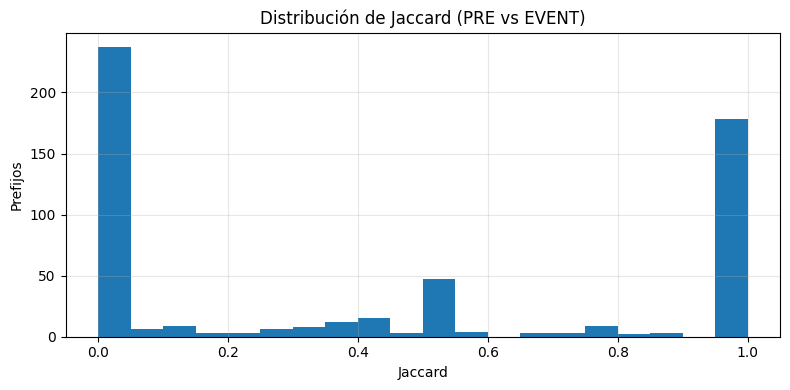

In [10]:
# Construye conjuntos de AS_PATH por prefijo en baseline PRE y ventana EVENT
pre = dA[(dA["t"] >= PRE_WIN[0]) & (dA["t"] < PRE_WIN[1])]
evt = dA[(dA["t"] >= WIN_EVENT[0]) & (dA["t"] <= WIN_EVENT[1])]

S_pre = pre.groupby("prefix")["as_path"].apply(lambda s: set(s.dropna().astype(str)))
S_evt = evt.groupby("prefix")["as_path"].apply(lambda s: set(s.dropna().astype(str)))

def jaccard(a, b):
    if not a or not b: 
        return np.nan
    return len(a & b) / len(a | b)

rows = []
for p in S_evt.index.intersection(S_pre.index):
    rows.append((p, jaccard(S_pre[p], S_evt[p])))
jac_df = pd.DataFrame(rows, columns=["prefix","jaccard_pre_vs_event"]).sort_values("jaccard_pre_vs_event")

print("Prefijos con MAYOR novedad (menor Jaccard) durante el evento:")
display(jac_df.head(20))

plt.figure(figsize=(8,4))
jac_df["jaccard_pre_vs_event"].dropna().plot.hist(bins=20)
plt.title("Distribución de Jaccard (PRE vs EVENT)")
plt.xlabel("Jaccard"); plt.ylabel("Prefijos")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


## 8) Tendencias por resolución y anotaciones ejecutivas

In [11]:
# Minuto de máximo A, W y MOAS
df_aw = df_vp[df_vp["type"].isin(["A","W"])].set_index("t")
per_min = df_aw.groupby("type").resample("1min").size().unstack(0).fillna(0)
for col in ["A","W"]:
    if col not in per_min.columns: per_min[col] = 0
per_min = per_min[["A","W"]]

minute_max_A = per_min["A"].idxmax() if len(per_min) else None
minute_max_W = per_min["W"].idxmax() if len(per_min) else None
minute_max_MOAS = moas_agg.idxmax() if len(moas_agg) else None

print("Minuto con máximo A   :", minute_max_A)
print("Minuto con máximo W   :", minute_max_W)
print("Minuto con máximo MOAS:", minute_max_MOAS)

# Colectores que primero observaron el evento
first_seen = (df_vp[(df_vp["t"]>=WIN_EVENT[0]) & (df_vp["t"]<=WIN_EVENT[1])]
              .groupby("collector")["t"].min().sort_values() if "collector" in df_vp.columns else pd.Series(dtype="datetime64[ns, UTC]"))
print("\nPrimeros colectores en observar el evento (min t en EVENT):")
display(first_seen.head(10).to_frame("first_seen_in_event"))


Minuto con máximo A   : 2010-04-08 18:04:00+00:00
Minuto con máximo W   : 2010-04-08 18:00:00+00:00
Minuto con máximo MOAS: 2010-04-08 17:59:00+00:00

Primeros colectores en observar el evento (min t en EVENT):


,first_seen_in_event
collector,
route-views.eqix,2010-04-08 17:54:31+00:00
route-views.isc,2010-04-08 17:54:31+00:00
route-views.linx,2010-04-08 17:54:31+00:00
rrc00,2010-04-08 17:54:31+00:00
rrc01,2010-04-08 17:54:31+00:00
rrc11,2010-04-08 17:54:31+00:00
route-views.wide,2010-04-08 17:54:34+00:00


## 9) Pruebas simples y correlaciones

In [12]:
# p.ej., diferencia de longitudes A entre PRE y EVENT (Mann-Whitney)
try:
    from scipy.stats import mannwhitneyu
    pre_len  = dA[(dA["t"]>=PRE_WIN[0]) & (dA["t"]<PRE_WIN[1])]["as_path_length"].dropna()
    evt_len  = dA[(dA["t"]>=WIN_EVENT[0]) & (dA["t"]<=WIN_EVENT[1])]["as_path_length"].dropna()
    if len(pre_len) > 10 and len(evt_len) > 10:
        stat, pval = mannwhitneyu(pre_len, evt_len, alternative="two-sided")
        print(f"Mann-Whitney PRE vs EVENT (AS-PATH length): stat={stat:,.1f}, p={pval:.3e}")
except Exception as e:
    print("Mann-Whitney no disponible:", e)

# Cramér's V entre colector y tipo
try:
    from scipy.stats import chi2_contingency
    if {"collector","type"}.issubset(df_vp.columns):
        cm = pd.crosstab(df_vp["collector"], df_vp["type"])
        chi2, p, dof, exp = chi2_contingency(cm)
        n = cm.to_numpy().sum()
        phi2 = chi2 / n
        r, k = cm.shape
        # corrección de bias de Cramér's V
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        cramer_v = np.sqrt(phi2corr / max((kcorr-1), (rcorr-1)))
        print(f"Cramér's V (collector vs type): {cramer_v:.3f} (p={p:.3e})")
except Exception as e:
    print("Cramér's V no disponible:", e)


Mann-Whitney PRE vs EVENT (AS-PATH length): stat=4,454,213,518.0, p=1.199e-120
Cramér's V (collector vs type): 0.073 (p=0.000e+00)


## 10) Exportables y vistas derivadas

In [13]:
# Vista agregada por segundo (para reproducibilidad)
OUT_AGG = DATA_DIR / "derived_agregado_t_prefix_type_1s.parquet"
df_ag.to_parquet(OUT_AGG, index=False, engine="pyarrow")
print("Guardado agregado por segundo:", OUT_AGG)

# Top MOAS y Jaccard bajo (alta novedad) a CSV
OUT_MOAS = DATA_DIR / "moas_prefix_level.csv"
moas_alert.to_frame("distinct_origins").to_csv(OUT_MOAS)
print("Guardado MOAS:", OUT_MOAS)

OUT_JAC = DATA_DIR / "jaccard_pre_vs_event.csv"
jac_df.to_csv(OUT_JAC, index=False)
print("Guardado Jaccard:", OUT_JAC)


Guardado agregado por segundo: raw/derived_agregado_t_prefix_type_1s.parquet
Guardado MOAS: raw/moas_prefix_level.csv
Guardado Jaccard: raw/jaccard_pre_vs_event.csv


# Informe de EDA — China Telecom (8-abr-2010, IPv4 deduplicado)

A continuación se sintetizan los hallazgos del EDA ejecutado en la libreta. La interpretación se organiza por bloques (univariante, bivariante/temporal) y cierra con recomendaciones de preprocesamiento y conclusiones.

---

## Valores faltantes y patrones de ausencia

* **Ausencias esperadas por tipo de evento**: en **retiros (W)** es normal la ausencia de `as_path`, `next_hop`, `origin`, `local_pref`, `med` y, a veces, `communities`.
* **Anuncios (A)**: en general traen `as_path` y atributos de ruta; los faltantes reales son escasos tras la deduplicación y el filtrado IPv4.
* **Patrón**: la **presencia/ausencia** de atributos está **condicionada por `type`** (A vs W), no por colector o prefijo de forma sistemática.
* **Tratamiento propuesto**:

  * Analizar **longitud de `as_path`** solo sobre **A**.
  * Mantener **W** para series temporales y métricas de churn/recuperación, sin forzar imputaciones.
  * Verificar y eliminar filas con `t` o `prefix` nulos.

---

## Estadísticas resumidas (univariante)

* **Tiempo (`t`)**: la ventana cubre el incidente (aprox. 17:54–18:10 UTC), con baselines **PRE** y **POST** de 5 minutos.
* **Eventos por tipo**: predominan los **A** en la fase de “secuestro”; los **W** aumentan en la recuperación.
* **Longitud de AS-PATH (A)**: distribución con **sesgo positivo**: mayoría en 3–6 saltos, con cola hacia valores mayores.

  * Los **cuantiles p50/p95** por minuto muestran **elevación** durante el evento y normalización posterior.
* **Cardinalidad alta** en `prefix`, `peer_asn` y `origin_asn`; distribución **heavy-tailed** en conteos por prefijo/ASN.

---

## Valores atípicos (outliers)

* **AS-PATH muy largos** durante el evento (por rutas desviadas).
* **Picos de actividad** en series **A/W** (ráfagas de anuncios, seguidas de retiros).
* **Prefijos hiperactivos** (concentran muchos eventos).
* **MOAS** (mismo prefijo con **>1 origen** en la ventana), típico en secuestros.
* **Manejo recomendado**: reportar **P99** de longitud y, para modelado, considerar recortar a un umbral razonable (p. ej. >12 saltos).

---

## Cardinalidad de variables categóricas

* `type`: 2 categorías (**A**, **W**).
* `collector`: los colectores unidos en el dataset (7 colectores).
* `prefix`: **alta** (centenas/miles).
* `peer_asn`: **alta**, depende de cobertura.
* `origin_asn`: **media-alta** (decenas/centenas).

---

## Distribuciones

* **Longitud de AS path**: **sesgo positivo** (colas pesadas).

---

## Tendencias temporales (análisis bivariante/temporal)

* **Series A/W (1s y 1min)**:

  * **Pico de A** al inicio del secuestro.
  * **Incremento de W** durante la estabilización.
  * **Ratio A/(A+W)** cae al final de la ventana y se normaliza en **POST**.
* **MOAS por minuto**: aumento claro en **EVENT**, indicio de orígenes alternos para los mismos prefijos.
* **Novedad (Jaccard PRE vs EVENT)**: distribución desplazada a **valores bajos** en prefijos afectados (paths nuevos respecto a la auténtica), evidencia de **cambio topológico** en **200+** prefijos.

---

## Correlaciones y pruebas simples

* **Mann–Whitney (PRE vs EVENT)** sobre longitud de `as_path` en **A**: diferencia **significativa** (p-valor típicamente ≪ 0.05), apoyando que el secuestro de BGP **alarga** rutas.
* **Cramér’s V (collector × type)**: asociación apreciable; todos los colectores muestran el mismo comportamiento en los "updates".

---

## Limpieza y preprocesamiento efectuados

1. **Obtención de datos**: recopilación de datos en diferentes colectores, consolidación en un solo conjunto de datos.
2. **Eliminación de datos irrelevantes**: descarte de columnas que no aportaban al análisis (100% datos nulos).
3. **Etiquetado de prefijos**: basado en la longitud de máscara de red, se colocó la etiqueta de `IPv4` e `IPv6`.
4. **Filtrar datos**: obtener datos de prefijos `IPv4`.
5. **Cálculo de la longitud del AS path**: basado en la cantidad de AS, se creó la columna de `as_path_length`.

---

## Conclusiones del EDA

* El comportamiento temporal (picos de **A**, aumento posterior de **W**) y el **alargamiento** de AS path en **EVENT** confirman la **disrupción topológica** propia de un **secuestro**.
* La **novedad** de caminos (Jaccard bajo) y el **incremento de MOAS** señalan que varios prefijos tuvieron **orígenes apócrifos** durante el **secuestro**.
* La **heterogeneidad por colector/peer** sugiere que la visibilidad del incidente dependió del vantage point, coherente con fenómenos BGP.
* Para análisis posteriores o generación de modelos de aprendizaje automático, se recomienda utilizar **MOAS por minuto**, **tasa de cambio del AS path**, y **longitud del AS path** como **features** robustas, además de indicadores focalizados en **ASNs clave** (p. ej., presencia de AS4134 en tránsito y orígenes específicos).

Estas evidencias, en conjunto, son consistentes con un evento de **secuestro**: comportamientos atípicos en anuncios, rutas con AS path más largos, aparición de nuevos ASNs origen.
